
# Weighted RRF 
it fuses **dataset_rank** vs **BM25** using weighted **RRF** with the constraint **`w_dataset + w_bm25 = 1`**, searches a dense weight grid, and visualizes results.



In [ ]:
# =================== Configuration ===================
import os, json, gzip, time, math, warnings, re
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **k: x

ABSOLUTE_JSONL_PATH = "/Users/zhangkemeng/Desktop/citeline_BM25/current_best_search_results.jsonl"
OUT_DIR = "/Users/zhangkemeng/Desktop/citeline_BM25/output"
os.makedirs(OUT_DIR, exist_ok=True)

RRF_K = 60
HIT_AT_K = [1, 5, 10, 20, 50, 100, 200, 500, 800, 1000]
WEIGHT_GRID = np.round(np.linspace(0.0, 1.0, 101), 2)
DROP_EMPTY_GOLD = True

CITATION_KEY = "citation_dois"
RESULT_DOI_FIELD = "doi"
RESULT_TEXT_FIELD = "text"
QUERY_FIELD_IN_RECORD = "sent_no_cit"

BATCH_QUERIES = 2
MAX_QUERIES = 14735
CHECKPOINT_EVERY = 20

BM25_K1 = 1.5
BM25_B = 0.75

if not os.path.exists(ABSOLUTE_JSONL_PATH):
    raise FileNotFoundError(ABSOLUTE_JSONL_PATH)7

print("Config ready")


Config ready


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# =================== JSONL reader ===================
def line_reader(path: str) -> Iterable[str]:
    open_fn = open
    if path.endswith(".gz"):
        open_fn = gzip.open
    with open_fn(path, "rt", encoding="utf-8") as f:
        for line in f:
            yield line

def jsonl_iter(path: str) -> Iterable[dict]:
    for line in line_reader(path):
        s = line.strip()
        if not s:
            continue
        try:
            yield json.loads(s)
        except Exception as e:
            warnings.warn(f"Skipping unparsable line: {str(e)[:160]}")
            continue

print("Reader ready")


Reader ready


In [3]:
# =================== Inspect sample JSON ===================
from itertools import islice

peek_entries = list(islice(jsonl_iter(ABSOLUTE_JSONL_PATH), 2))
if not peek_entries:
    print('No data found in JSONL file.')
else:
    for idx, entry in enumerate(peek_entries, 1):
        print(f'Entry {idx} top-level keys: {list(entry.keys())}')
        record = entry.get('record')
        if isinstance(record, dict):
            print('  record keys:', list(record.keys()))
        results = entry.get('results') or []
        if results:
            first_result = results[0]
            print('  first result keys:', list(first_result.keys()))
            print('  first result doi:', first_result.get(RESULT_DOI_FIELD))
        print('-' * 50)


Entry 1 top-level keys: ['record', 'results']
  record keys: ['source_doi', 'sent_original', 'sent_no_cit', 'sent_idx', 'citation_dois', 'pubdate', 'resolved_bibcodes', 'sent_cit_masked', 'vector_original', 'add_prev_2', 'vector_add_prev_2']
  first result keys: ['text', 'doi', 'pubdate', 'citation_count', 'metric']
  first result doi: 10.1093/mnras/stx2000
--------------------------------------------------
Entry 2 top-level keys: ['record', 'results']
  record keys: ['source_doi', 'sent_original', 'sent_no_cit', 'sent_idx', 'citation_dois', 'pubdate', 'resolved_bibcodes', 'sent_cit_masked', 'vector_original', 'add_prev_2', 'vector_add_prev_2']
  first result keys: ['text', 'doi', 'pubdate', 'citation_count', 'metric']
  first result doi: 10.1093/mnras/stab323
--------------------------------------------------


In [4]:
# =================== Utilities ===================
DOI_PREFIXES = ("https://doi.org/", "http://doi.org/", "doi:", "doi.org/")

def normalize_doi(raw: Optional[str]) -> Optional[str]:
    if raw is None:
        return None
    value = str(raw).strip()
    if not value:
        return None
    lower = value.lower()
    for prefix in DOI_PREFIXES:
        if lower.startswith(prefix):
            value = value[len(prefix):]
            lower = value.lower()
            break
    return lower

def extract_gold(entry: dict) -> Set[str]:
    record = entry.get("record") or {}
    raw = entry.get(CITATION_KEY) or record.get(CITATION_KEY) or []
    return {normalize_doi(x) for x in raw if normalize_doi(x)}

def get_query_text(entry: dict) -> str:
    record = entry.get("record") or {}
    if isinstance(record, dict):
        text = record.get(QUERY_FIELD_IN_RECORD)
        if isinstance(text, str) and text.strip():
            return text
    text = entry.get("query")
    if isinstance(text, str):
        return text
    return ""

def prepare_results(entry: dict) -> Tuple[List[str], np.ndarray, List[str]]:
    results = entry.get("results") or []
    dois: List[str] = []
    dataset_ranks: List[float] = []
    texts: List[str] = []
    for idx, result in enumerate(results, start=1):
        doi = normalize_doi(result.get(RESULT_DOI_FIELD))
        if not doi:
            continue
        rank = result.get("rank") or result.get("final_rank") or idx
        try:
            rank_value = float(rank)
        except Exception:
            rank_value = float(idx)
        if rank_value < 1:
            rank_value = float(idx)
        text = result.get(RESULT_TEXT_FIELD) or ""
        dois.append(doi)
        dataset_ranks.append(rank_value)
        texts.append(text)
    if not dois:
        return [], np.array([], dtype=float), []
    return dois, np.asarray(dataset_ranks, dtype=float), texts

print("Utilities ready")


Utilities ready


In [5]:
# =================== BM25 ===================
_WORD_RE = re.compile(r"[A-Za-z0-9_]+", re.UNICODE)

def tokenize(text: str) -> List[str]:
    return [token.lower() for token in _WORD_RE.findall(text or "")]

def okapi_bm25_scores(query_text: str, doc_texts: List[str], k1: float = BM25_K1, b: float = BM25_B) -> np.ndarray:
    q_tokens = tokenize(query_text)
    docs_tokens = [tokenize(t) for t in doc_texts]
    N = len(docs_tokens)
    if N == 0:
        return np.zeros((0,), dtype=float)
    doc_len = np.array([len(toks) for toks in docs_tokens], dtype=float)
    avgdl = doc_len.mean() if N else 0.0
    tf_list = []
    for toks in docs_tokens:
        tf = {}
        for token in toks:
            tf[token] = tf.get(token, 0) + 1
        tf_list.append(tf)
    query_terms = set(q_tokens)
    df = {token: sum(1 for tf in tf_list if token in tf) for token in query_terms}
    scores = np.zeros(N, dtype=float)
    for i, tf in enumerate(tf_list):
        dl = doc_len[i]
        norm = k1 * (1.0 - b + b * (dl / avgdl)) if avgdl > 0 else k1
        score = 0.0
        for token in query_terms:
            f = tf.get(token, 0.0)
            if f <= 0:
                continue
            idf = math.log(1.0 + (N - df.get(token, 0) + 0.5) / (df.get(token, 0) + 0.5))
            score += idf * ((f * (k1 + 1.0)) / (f + norm))
        scores[i] = score
    return scores

print("BM25 ready")


BM25 ready


In [6]:
# =================== RRF helpers ===================
def hits_for_weights(dois: List[str],
                     dataset_ranks: np.ndarray,
                     bm25_ranks: np.ndarray,
                     weight_grid: np.ndarray,
                     ks: Sequence[int],
                     gold_ids: Set[str],
                     rrf_k: int) -> np.ndarray:
    W = len(weight_grid)
    hits = np.zeros((W, len(ks)), dtype=np.int32)
    if len(dois) == 0 or not gold_ids:
        return hits
    dois_arr = np.asarray(dois, dtype=object)
    ds_scores = 1.0 / (rrf_k + dataset_ranks)
    bm_scores = 1.0 / (rrf_k + bm25_ranks)
    Kmax = max(ks)
    for wi, w in enumerate(weight_grid):
        combined = w * ds_scores + (1.0 - w) * bm_scores
        order = np.argsort(-combined, kind="mergesort")
        top_order = order[:Kmax]
        for kj, top_k in enumerate(ks):
            top_ids = {str(x) for x in dois_arr[top_order[:top_k]]}
            if gold_ids & top_ids:
                hits[wi, kj] = 1
    return hits

print("RRF helpers ready")


RRF helpers ready


In [ ]:
# =================== Streaming evaluator  ===================
def build_metrics_df(weight_grid: np.ndarray, hits_acc: np.ndarray, total: int, Ks: Sequence[int]) -> pd.DataFrame:
    data = {"w_dataset": weight_grid.astype(float), "w_bm25": (1.0 - weight_grid).astype(float)}
    denom = float(total)
    for j, K in enumerate(Ks):
        col = f"Hit@{K}"
        data[col] = np.nan if denom <= 0 else (hits_acc[:, j].astype(float) / denom)
    return pd.DataFrame(data).sort_values("w_dataset").reset_index(drop=True)

def evaluate_singlefile(jsonl_path: str,
                        weight_grid: np.ndarray,
                        ks: Sequence[int],
                        rrf_k: int,
                        drop_empty_gold: bool,
                        batch_queries: int,
                        max_queries: Optional[int],
                        checkpoint_every: Optional[int],
                        out_dir: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    Ks = list(ks)
    hits_acc = np.zeros((len(weight_grid), len(Ks)), dtype=np.int64)
    effective_queries = 0

    batch: List[dict] = []
    batch_idx = 0
    t0 = time.time()

    def flush_batch(batch_list: List[dict], batch_id: int):
        nonlocal hits_acc, effective_queries
        if not batch_list:
            return
        for entry in batch_list:
            gold = extract_gold(entry)
            if drop_empty_gold and not gold:
                continue
            dois, ds_ranks, doc_texts = prepare_results(entry)
            if not dois:
                continue
            bm_scores = okapi_bm25_scores(get_query_text(entry), doc_texts)
            if bm_scores.size == 0:
                continue
            order = np.argsort(-bm_scores, kind="mergesort")
            bm_ranks = np.empty_like(bm_scores, dtype=float)
            bm_ranks[order] = np.arange(1, len(bm_scores) + 1, dtype=float)
            hits = hits_for_weights(dois, ds_ranks, bm_ranks, weight_grid, Ks, gold, rrf_k)
            hits_acc += hits
            effective_queries += 1
        if checkpoint_every and effective_queries and (batch_id % checkpoint_every == 0):
            tmp_df = build_metrics_df(weight_grid, hits_acc, effective_queries, Ks)
            tmp_df.to_csv(os.path.join(out_dir, "rrf_weight_tuning_metrics_partial.csv"), index=False)

    for i, entry in enumerate(tqdm(jsonl_iter(jsonl_path), desc="Streaming JSONL (single-file BM25 recompute)")):
        batch.append(entry)
        if max_queries is not None and (i + 1) >= max_queries:
            batch_idx += 1
            flush_batch(batch, batch_idx)
            batch.clear()
            break
        if len(batch) >= batch_queries:
            batch_idx += 1
            flush_batch(batch, batch_idx)
            batch.clear()

    if batch:
        batch_idx += 1
        flush_batch(batch, batch_idx)
        batch.clear()

    elapsed = time.time() - t0
    metrics_df = build_metrics_df(weight_grid, hits_acc, effective_queries, Ks)
    stats = {
        "effective_queries": int(effective_queries),
        "elapsed_sec": elapsed,
        "per_effective_query_ms": (elapsed / max(1, effective_queries)) * 1000.0,
    }
    return metrics_df, stats

print("Evaluator ready")


Evaluator ready


In [8]:

# =================== Run evaluation ===================
metrics_df, stats = evaluate_singlefile(
    ABSOLUTE_JSONL_PATH,
    weight_grid=WEIGHT_GRID,
    ks=HIT_AT_K,
    rrf_k=RRF_K,
    drop_empty_gold=DROP_EMPTY_GOLD,
    batch_queries=BATCH_QUERIES,
    max_queries=MAX_QUERIES,
    checkpoint_every=CHECKPOINT_EVERY,
    out_dir=OUT_DIR
)
print("Stats:", stats)

csv_path = os.path.join(OUT_DIR, "rrf_weight_tuning_metrics.csv")
metrics_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
metrics_df.head()


Streaming JSONL (single-file BM25 recompute): 14734it [13:08, 18.68it/s]

Stats: {'effective_queries': 14735, 'elapsed_sec': 788.9080500602722, 'per_effective_query_ms': 53.539738721430076}
Saved: /Users/zhangkemeng/Desktop/citeline_BM25/output/rrf_weight_tuning_metrics.csv


,w_dataset,w_bm25,Hit@1,Hit@5,Hit@10,Hit@20,Hit@50,Hit@100,Hit@200,Hit@500,Hit@800,Hit@1000
0,0.00,1.00,0.260129,0.418324,0.515100,0.618392,0.746861,0.831558,0.896641,0.946793,0.959688,0.963353
1,0.01,0.99,0.260129,0.418324,0.515100,0.618392,0.747540,0.831897,0.896709,0.946793,0.959484,0.963353
2,0.02,0.98,0.267866,0.423889,0.518426,0.620020,0.748558,0.833051,0.896844,0.946929,0.959416,0.963353
3,0.03,0.97,0.274449,0.427418,0.521412,0.622396,0.749712,0.833865,0.897523,0.947268,0.959552,0.963353
4,0.04,0.96,0.284425,0.432168,0.524194,0.624567,0.750865,0.834136,0.897659,0.947540,0.959552,0.963353


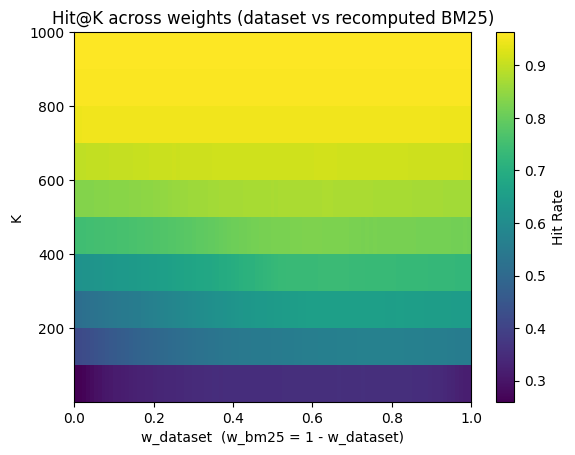

Saved: /Users/zhangkemeng/Desktop/citeline_BM25/output/rrf_heatmap.png


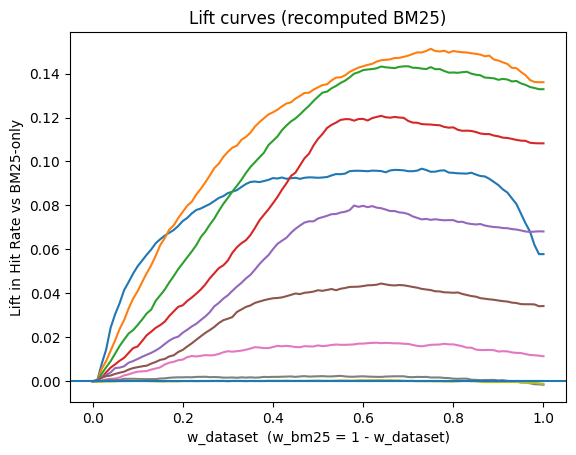

Saved: /Users/zhangkemeng/Desktop/citeline_BM25/output/rrf_lift_over_bm25.png
Saved: /Users/zhangkemeng/Desktop/citeline_BM25/output/rrf_analysis_summary.csv


,K,BM25_only,Dataset_only,Best_w_dataset,Best_w_bm25,Best_Hit,Lift_over_BM25,Lift_over_Dataset
0,1,0.260129,0.317950,0.73,0.27,0.356837,0.096709,0.038887
1,5,0.418324,0.554394,0.75,0.25,0.569596,0.151272,0.015202
2,10,0.515100,0.647981,0.70,0.30,0.658432,0.143332,0.010451
3,20,0.618392,0.726637,0.64,0.36,0.739125,0.120733,0.012487
4,50,0.746861,0.814998,0.58,0.42,0.826807,0.079946,0.011809
5,100,0.831558,0.865762,0.64,0.36,0.876010,0.044452,0.010248
6,200,0.896641,0.907974,0.63,0.37,0.914150,0.017509,0.006176
7,500,0.946793,0.945165,0.55,0.45,0.949237,0.002443,0.004072
8,800,0.959688,0.958466,0.63,0.37,0.960163,0.000475,0.001697
9,1000,0.963353,0.963353,0.00,1.00,0.963353,0.000000,0.000000


In [9]:

# =================== Visualizations & summary ===================
# Heatmap
weights = metrics_df["w_dataset"].values
Ks = sorted([int(c.split("@")[1]) for c in metrics_df.columns if c.startswith("Hit@")])
Z = np.zeros((len(Ks), len(weights)), dtype=float); Z[:] = np.nan
for i, K in enumerate(Ks):
    Z[i, :] = metrics_df[f"Hit@{K}"].values

plt.figure()
plt.imshow(Z, aspect="auto", origin="lower", extent=[weights.min(), weights.max(), min(Ks), max(Ks)])
plt.colorbar(label="Hit Rate")
plt.xlabel("w_dataset  (w_bm25 = 1 - w_dataset)")
plt.ylabel("K")
plt.title("Hit@K across weights (dataset vs recomputed BM25)")
heatmap_path = os.path.join(OUT_DIR, "rrf_heatmap.png")
plt.savefig(heatmap_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved:", heatmap_path)

# Lift vs BM25-only
plt.figure()
bm25_row = metrics_df.loc[(metrics_df["w_dataset"] - 0.0).abs().idxmin()]
for K in Ks:
    col = f"Hit@{K}"
    base = float(bm25_row[col]) if pd.notna(bm25_row[col]) else np.nan
    if not np.isnan(base):
        lift = metrics_df[col].values - base
        plt.plot(weights, lift, label=f"Hit@{K} lift vs BM25-only")
plt.axhline(0.0)
plt.xlabel("w_dataset  (w_bm25 = 1 - w_dataset)")
plt.ylabel("Lift in Hit Rate vs BM25-only")
plt.title("Lift curves (recomputed BM25)")
lift_path = os.path.join(OUT_DIR, "rrf_lift_over_bm25.png")
plt.savefig(lift_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved:", lift_path)

# Best-by-K bars + summary CSV
rows = []
for K in Ks:
    col = f"Hit@{K}"
    idx = metrics_df[col].idxmax()
    best = metrics_df.loc[idx]
    bm25_only = metrics_df.loc[(metrics_df["w_dataset"] - 0.0).abs().idxmin(), col]
    ds_only   = metrics_df.loc[(metrics_df["w_dataset"] - 1.0).abs().idxmin(), col]
    rows.append({
        "K": K,
        "BM25_only": float(bm25_only),
        "Dataset_only": float(ds_only),
        "Best_w_dataset": float(best["w_dataset"]),
        "Best_w_bm25": float(best["w_bm25"]),
        "Best_Hit": float(best[col]),
        "Lift_over_BM25": float(best[col] - bm25_only),
        "Lift_over_Dataset": float(best[col] - ds_only),
    })
summary_df = pd.DataFrame(rows).sort_values("K").reset_index(drop=True)
summary_csv = os.path.join(OUT_DIR, "rrf_analysis_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("Saved:", summary_csv)
summary_df


In [10]:
import pandas as pd
import numpy as np

# >>> Fill this with your actual path <<<
METRICS_CSV = "/Users/zhangkemeng/Desktop/citeline_BM25/output/rrf_weight_tuning_metrics.csv"

df = pd.read_csv(METRICS_CSV)
Ks = sorted(int(c.split("@")[1]) for c in df.columns if c.startswith("Hit@"))

# pick primary K if available
PRIMARY_K = 10 if "Hit@10" in df.columns else Ks[len(Ks)//2]

bm_row = df.iloc[(df["w_dataset"]-0.0).abs().idxmin()]
ds_row = df.iloc[(df["w_dataset"]-1.0).abs().idxmin()]

lifts = []
best_ws = []
print("=== Quick verdict summary ===")
for K in Ks:
    col = f"Hit@{K}"
    idx = df[col].idxmax()
    best = df.loc[idx]
    lift_bm = float(best[col] - bm_row[col])
    lift_ds = float(best[col] - ds_row[col])
    lifts.append(lift_bm)
    best_ws.append(float(best["w_dataset"]))
    print(f"K={K:<3d}  Best={best[col]:.4f}  BM25={bm_row[col]:.4f}  Dataset={ds_row[col]:.4f}  "
          f"Lift_vs_BM25={lift_bm:+.4f}  Lift_vs_Dataset={lift_ds:+.4f}  w_dataset*={best['w_dataset']:.2f}")

avg_lift = float(np.nanmean(lifts))
best_w_primary = float(df.loc[df[f"Hit@{PRIMARY_K}"].idxmax(), "w_dataset"])
pos_k = sum(1 for x in lifts if x >= 0.005)  # >=0.5% absolute lift

if (pos_k >= 2 and avg_lift >= 0.005 and 0.05 < best_w_primary < 0.95):
    verdict = "Likely BENEFICIAL: fusion shows consistent positive lifts and non-trivial optimal weight in (0,1)."
elif (avg_lift >= 0.002 and 0.01 < best_w_primary < 0.99):
    verdict = "Borderline: small lifts; consider plateau width, stability and business trade-offs."
else:
    verdict = "NOT beneficial enough: best weights sit at edges or lifts are negligible."

print("\nVERDICT:", verdict)


=== Quick verdict summary ===
K=1    Best=0.3568  BM25=0.2601  Dataset=0.3180  Lift_vs_BM25=+0.0967  Lift_vs_Dataset=+0.0389  w_dataset*=0.73
K=5    Best=0.5696  BM25=0.4183  Dataset=0.5544  Lift_vs_BM25=+0.1513  Lift_vs_Dataset=+0.0152  w_dataset*=0.75
K=10   Best=0.6584  BM25=0.5151  Dataset=0.6480  Lift_vs_BM25=+0.1433  Lift_vs_Dataset=+0.0105  w_dataset*=0.70
K=20   Best=0.7391  BM25=0.6184  Dataset=0.7266  Lift_vs_BM25=+0.1207  Lift_vs_Dataset=+0.0125  w_dataset*=0.64
K=50   Best=0.8268  BM25=0.7469  Dataset=0.8150  Lift_vs_BM25=+0.0799  Lift_vs_Dataset=+0.0118  w_dataset*=0.58
K=100  Best=0.8760  BM25=0.8316  Dataset=0.8658  Lift_vs_BM25=+0.0445  Lift_vs_Dataset=+0.0102  w_dataset*=0.64
K=200  Best=0.9141  BM25=0.8966  Dataset=0.9080  Lift_vs_BM25=+0.0175  Lift_vs_Dataset=+0.0062  w_dataset*=0.63
K=500  Best=0.9492  BM25=0.9468  Dataset=0.9452  Lift_vs_BM25=+0.0024  Lift_vs_Dataset=+0.0041  w_dataset*=0.55
K=800  Best=0.9602  BM25=0.9597  Dataset=0.9585  Lift_vs_BM25=+0.0005  Lif

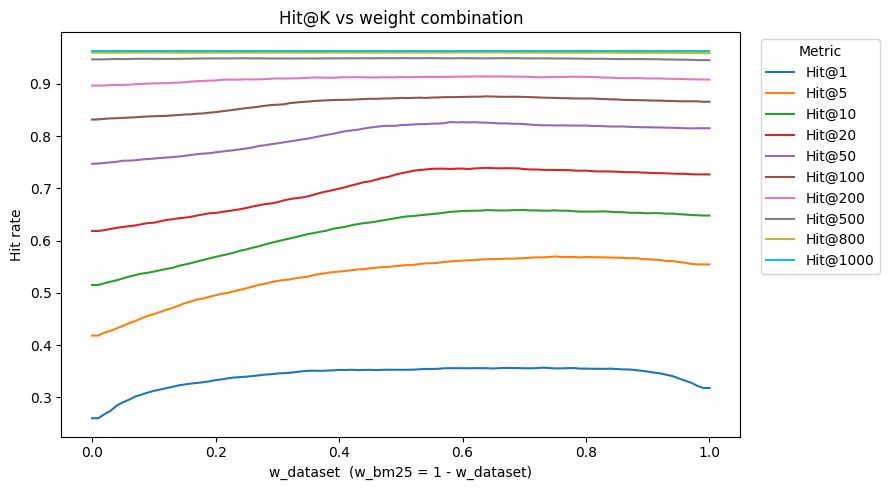

Saved: /Users/zhangkemeng/Desktop/citeline_BM25/output/rrf_weight_tuning_curves.png


In [13]:
# =================== Hit@K vs weight curves ===================
if 'metrics_df' not in globals():
    metrics_path = os.path.join(OUT_DIR, 'rrf_weight_tuning_metrics.csv')
    metrics_df = pd.read_csv(metrics_path)

weights = metrics_df['w_dataset'].values
hit_cols = sorted(
    [col for col in metrics_df.columns if col.startswith('Hit@')],
    key=lambda c: int(c.split('@')[1])
)

plt.figure(figsize=(9, 5))
for col in hit_cols:
    plt.plot(weights, metrics_df[col].values, label=col)
plt.xlabel('w_dataset  (w_bm25 = 1 - w_dataset)')
plt.ylabel('Hit rate')
plt.title('Hit@K vs weight combination')
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

curves_path = os.path.join(OUT_DIR, 'rrf_weight_tuning_curves.png')
plt.savefig(curves_path, dpi=150)
plt.show()
print('Saved:', curves_path)
